In [1]:
import numpy as np
import pandas as pd

data = pd.read_excel("./instrument.xlsx")
columns = data.columns.tolist()
columns

['T', 'x', 'y', 'z', 'Vx', 'Vy', 'Vz', 'V', 'Ax', 'Ay', 'Az', 'A']

In [2]:
def create_new_scheme(nums, file_name):
    """
    创建模拟数据
    :param nums: 创建模拟数据集的个数
    :param file_name: 原始数据集路径，xlsx格式
    """
    data = pd.read_excel(file_name)
    save_name = file_name.split(".")[0]
    i = 0
    while i < nums:
        n = np.random.randint(10)
        dd = data.copy()
        # if np.random.rand() > 0.5:
        for col in columns:
            if col == 'T':
                continue
            dd[col] = dd[col].map(lambda x:x + n * np.random.rand())
        dd.to_excel(save_name + f"instrument{i}.xlsx", index=0)
        i += 1
        
create_new_scheme(10, "./instrument.xlsx")
print("Done!")

Done!


In [3]:
import os
import glob
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.metrics import mean_squared_error, r2_score
import warnings


warnings.filterwarnings('ignore')

# 数据预处理
# 对每个数据表进行清洗、去重、填充缺失值等预处理工作，确保数据的质量
data = []
data_files = glob.glob("./*.xlsx")
# data_tables = []
# for file in data_files:
#     data_table = pd.read_excel(file)
#     data_tables.append(data_table)
# 数据读取与特征工程
for file in data_files:
    # 读取数据表
    table = pd.read_excel(file)
    table["speed"] = (table["Vx"] ** 2 + table["Vy"] ** 2 + table["Vz"] ** 2) ** 0.5
    table["acceleration"] = (table["Ax"] ** 2  + table["Ay"] ** 2 + table["Az"] ** 2) ** 0.5
    # 计算位移
    table["dx"] = table["x"].diff().fillna(0)
    table["dy"] = table["y"].diff().fillna(0)
    table["dz"] = table["z"].diff().fillna(0)
    table["displacement"] = (table["dx"] ** 2 + table["dy"] ** 2 + table["dz"] ** 2) ** 0.5
    # 特征提取
#     X = df[["T", "x", "y", "z"，"Dx", "Dy", "Dz"]].values
#     y = df[["Vx", "Vy", "Vz", "Ax", "Ay", "Az", "A", "Dx", "Dy", "Dz"]].values
    print(table)
    X = table[["T", "x", "y", "z"]].values
    y = table[["Vx", "Vy", "Vz", "Ax", "Ay", "Az", "A"]].values
    # 将速度、加速度和位移分开，用于模型训练
    y_vel = y[:, :3]
    y_acc = y[:, 3:6]
#     y_disp = y[:, 6:9]
    # 将时间作为索引
    # df.set_index("T", inplace=True)
    # 将每个数据表加入数据列表中
    data.append((X, y_vel, y_acc, table))


num_tables = len(data_files)
# 数据划分
train_data = data[:int(num_tables*0.7)]
test_data = data[int(num_tables*0.3):]

# 定义高斯过程回归模型
# kernel 采用了 RBF 核和 WhiteKernel 噪声核，可通过调整 length_scale 和 noise_level 参数控制模型的灵活度和泛化能力。
kernel = RBF(length_scale=1.0) + WhiteKernel(noise_level=1.0)  
gpr = GaussianProcessRegressor(kernel=kernel)

# 对每个数据表进行模型训练和预测。
# 首先，分别训练速度和加速度模型，然后使用训练好的模型对测试集进行预测，得到预测值和标准差。
# 将预测结果加入测试数据表中，并计算每个数据点与拟合曲线之间的标准差，将预测结果保存到新的数据表中。
for i, (X_train, y_train_vel, y_train_acc, _) in enumerate(train_data):
    # 训练速度和加速度模型
    gpr_vel = gpr.fit(X_train, y_train_vel)
    gpr_acc = gpr.fit(X_train, y_train_acc)

    # 预测速度和加速度
    X_test, y_test_vel, y_test_acc, df = test_data[i]
    y_pred_vel, std_vel = gpr_vel.predict(X_test, return_std=True)
    y_pred_acc, std_acc = gpr_acc.predict(X_test, return_std=True)

#     # 对速度进行积分，得到位移增量
#     dt = np.diff(X_test[:, 0])[:, np.newaxis]
#     delta_pos = y_pred_vel[:-1, :] * dt + 0.5 * y_pred_acc[:-1, :] * dt ** 2

#     # 计算当前的位移
#     pos_pred = np.zeros_like(y_pred_vel)
#     pos_pred[0, :] = train_data.iloc[-1, [1, 2, 3]].values + delta_pos[0, :]
#     for j in range(1, len(delta_pos)):
#         pos_pred[j, :] = pos_pred[j-1, :] + delta_pos[j, :]
    
#     # 计算标准差
#     x0 = X_test[0, 1:] # 初始位置
#     y_test_displacement = X_test[:, 1:] - x0 # 真实位移
#     y_pred_displacement = pos_pred - x0 # 预测位移
#     std_displacement = np.std(y_test_displacement - y_pred_displacement)
    
    
    
    # 计算每个数据点与拟合曲线之间的标准差
    df["std_vel"] = std_vel
    df["std_acc"] = std_acc
#     df_test["std_displacement"] = std_displacement
    

    # 将预测结果加入测试数据表中
    df["Vx_pred"] = y_pred_vel[:, 0]
    df["Vy_pred"] = y_pred_vel[:, 1]
    df["Vz_pred"] = y_pred_vel[:, 2]
    df["Ax_pred"] = y_pred_acc[:, 0]
    df["Ay_pred"] = y_pred_acc[:, 1]
    df["Az_pred"] = y_pred_acc[:, 2]
#     df_test["x_pred"] = pos_pred[:, 0]
#     df_test["y_pred"] = pos_pred[:, 1]
#     df_test["z_pred"] = pos_pred[:, 2]

    # 将预测结果保存到新的数据表中
    # df.to_csv(f"result_{i}.csv", index=False)
print(df)

       T              x              y             z         Vx         Vy  \
0      1  440769.709445 -103437.967784  1.147020e+06  22.098960 -68.587537   
1      2  440791.402198 -103518.251293  1.146937e+06  21.394611 -67.274772   
2      3  440803.933989 -103597.529707  1.146860e+06  22.283581 -74.265940   
3      4  440816.340699 -103673.146223  1.146780e+06  23.173061 -76.215547   
4      5  440837.173263 -103749.178111  1.146697e+06  22.747849 -70.799983   
..   ...            ...            ...           ...        ...        ...   
96    97  442394.031394 -111755.220579  1.140938e+06  21.106132 -95.029585   
97    98  442409.049721 -111851.082250  1.140889e+06  19.169545 -90.822046   
98    99  442425.573285 -111948.736566  1.140848e+06  24.471755 -95.413067   
99   100  442446.870108 -112042.789412  1.140803e+06  21.530429 -94.017773   
100  101  442460.521221 -112140.151253  1.140764e+06  18.367537 -95.127974   

            Vz           V        Ax        Ay        Az       

       T              x              y             z         Vx         Vy  \
0      1  440768.380559 -103445.461334  1.147017e+06  15.179262 -72.969555   
1      2  440784.490621 -103518.327902  1.146936e+06  15.488524 -74.898093   
2      3  440800.642462 -103598.553256  1.146854e+06  15.797785 -76.826632   
3      4  440816.161544 -103675.055037  1.146773e+06  16.107047 -78.755170   
4      5  440831.534023 -103751.230925  1.146692e+06  16.176682 -78.367603   
..   ...            ...            ...           ...        ...        ...   
96    97  442388.666729 -111760.756114  1.140930e+06  17.736493 -96.038470   
97    98  442406.306349 -111857.185047  1.140886e+06  17.731036 -96.145196   
98    99  442424.106607 -111953.228420  1.140842e+06  17.769165 -96.269959   
99   100  442441.815552 -112049.244906  1.140799e+06  17.807295 -96.394721   
100  101  442459.757954 -112146.075977  1.140756e+06  17.845424 -96.519483   

            Vz           V        Ax        Ay        Az       

Polynomial Regression (V): MSE = 1.6524, R-squared = 0.7446


/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

Best parameters: {'kernel__k1__length_scale': 0.1, 'kernel__k2__noise_level': 10.0}
Best score: -1.1030222360218802
Gaussian Process Regression (V): MSE = 1.4064, R-squared = 0.7826
Polynomial Regression (A): MSE = 1.1116, R-squared = 0.0215


/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/skl

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/skl

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sk

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/skl

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/skl

Best parameters: {'kernel__k1__length_scale': 5.6, 'kernel__k2__noise_level': 7.800000000000001}
Best score: -0.0943637482206734
Gaussian Process Regression (A): MSE = 0.0000, R-squared = 1.0000
Polynomial Regression (displacement): MSE = 115.1428, R-squared = 0.0909


/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/s

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Best parameters: {'kernel__k1__length_scale': 4.5, 'kernel__k2__noise_level': 10.0}
Best score: -0.39160194222479244
Gaussian Process Regression (displacement): MSE = 0.0000, R-squared = 1.0000
Saving processed data to ./instrument9_processed.csv
./instrument9.xlsx Done!
--------------------------------------------
Polynomial Regression (V): MSE = 1.4840, R-squared = 0.7135


/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

Best parameters: {'kernel__k1__length_scale': 8.9, 'kernel__k2__noise_level': 8.9}
Best score: -0.9708984310114854
Gaussian Process Regression (V): MSE = 1.2748, R-squared = 0.7539
Polynomial Regression (A): MSE = 1.4377, R-squared = 0.0518


/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sk

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/skl

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/skl

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sk

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sk

Best parameters: {'kernel__k1__length_scale': 0.1, 'kernel__k2__noise_level': 7.800000000000001}
Best score: -0.1778925471502179
Gaussian Process Regression (A): MSE = 0.0000, R-squared = 1.0000
Polynomial Regression (displacement): MSE = 114.2153, R-squared = 0.0901


/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sk

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sk

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sk

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/s

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sk

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/s

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/skl

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/skl

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sk

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sk

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/s

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/s

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/skl

Best parameters: {'kernel__k1__length_scale': 3.4000000000000004, 'kernel__k2__noise_level': 5.6}
Best score: -0.6850417524111133
Gaussian Process Regression (displacement): MSE = 0.0000, R-squared = 1.0000
Saving processed data to ./instrument5_processed.csv
./instrument5.xlsx Done!
--------------------------------------------
Polynomial Regression (V): MSE = 1.0897, R-squared = 0.7829
Best parameters: {'kernel__k1__length_scale': 10.0, 'kernel__k2__noise_level': 5.6}
Best score: -1.4590409272243683
Gaussian Process Regression (V): MSE = 0.7837, R-squared = 0.8438
Polynomial Regression (A): MSE = 0.7327, R-squared = 0.0509


/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/skl

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sk

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/skl

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/skl

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/skl

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/skl

Best parameters: {'kernel__k1__length_scale': 0.1, 'kernel__k2__noise_level': 4.5}
Best score: -0.03156549994352527
Gaussian Process Regression (A): MSE = 0.0000, R-squared = 1.0000
Polynomial Regression (displacement): MSE = 112.3136, R-squared = 0.0948


/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

Best parameters: {'kernel__k1__length_scale': 10.0, 'kernel__k2__noise_level': 4.5}
Best score: -0.7581365892894865
Gaussian Process Regression (displacement): MSE = 5.6697, R-squared = 0.9543
Saving processed data to ./instrument4_processed.csv
./instrument4.xlsx Done!
--------------------------------------------
Polynomial Regression (V): MSE = 1.2956, R-squared = 0.7744


/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

Best parameters: {'kernel__k1__length_scale': 0.1, 'kernel__k2__noise_level': 0.1}
Best score: -1.4653611531400346
Gaussian Process Regression (V): MSE = 0.0000, R-squared = 1.0000
Polynomial Regression (A): MSE = 1.1801, R-squared = 0.0803


/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/skl

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/skl

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sk

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/skl

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/skl

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/skl

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sk

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/skl

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sk

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sk

Best parameters: {'kernel__k1__length_scale': 0.1, 'kernel__k2__noise_level': 1.2000000000000002}
Best score: -0.1649558555607563
Gaussian Process Regression (A): MSE = 0.0000, R-squared = 1.0000
Polynomial Regression (displacement): MSE = 113.9827, R-squared = 0.0965


/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/s

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

Best parameters: {'kernel__k1__length_scale': 6.7, 'kernel__k2__noise_level': 8.9}
Best score: -0.5048443474874293
Gaussian Process Regression (displacement): MSE = 9.4391, R-squared = 0.9252
Saving processed data to ./instrument8_processed.csv
./instrument8.xlsx Done!
--------------------------------------------
Polynomial Regression (V): MSE = 1.5399, R-squared = 0.7064


/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

Best parameters: {'kernel__k1__length_scale': 0.1, 'kernel__k2__noise_level': 0.1}
Best score: -0.8403976976077947
Gaussian Process Regression (V): MSE = 1.4394, R-squared = 0.7256
Polynomial Regression (A): MSE = 1.3493, R-squared = 0.0662


/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/s

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/skl

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/skl

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/s

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sk

Best parameters: {'kernel__k1__length_scale': 1.2000000000000002, 'kernel__k2__noise_level': 7.800000000000001}
Best score: -0.124658541308643
Gaussian Process Regression (A): MSE = 0.0000, R-squared = 1.0000
Polynomial Regression (displacement): MSE = 114.2133, R-squared = 0.0920


/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

Best parameters: {'kernel__k1__length_scale': 2.3000000000000003, 'kernel__k2__noise_level': 7.800000000000001}
Best score: -0.3775537501473906
Gaussian Process Regression (displacement): MSE = 0.3579, R-squared = 0.9972
Saving processed data to ./instrument3_processed.csv
./instrument3.xlsx Done!
--------------------------------------------
Polynomial Regression (V): MSE = 0.5891, R-squared = 0.8639


/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

Best parameters: {'kernel__k1__length_scale': 8.9, 'kernel__k2__noise_level': 5.6}
Best score: -3.5898444199493014
Gaussian Process Regression (V): MSE = 0.4611, R-squared = 0.8935
Polynomial Regression (A): MSE = 0.3384, R-squared = 0.1487


/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/skl

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/skl

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/skl

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/skl

Best parameters: {'kernel__k1__length_scale': 8.9, 'kernel__k2__noise_level': 7.800000000000001}
Best score: -0.24203564439417868
Gaussian Process Regression (A): MSE = 0.0000, R-squared = 1.0000
Polynomial Regression (displacement): MSE = 111.4375, R-squared = 0.0946


/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

Best parameters: {'kernel__k1__length_scale': 7.800000000000001, 'kernel__k2__noise_level': 3.4000000000000004}
Best score: -1.833379413149619
Gaussian Process Regression (displacement): MSE = 1.7789, R-squared = 0.9855
Saving processed data to ./instrument2_processed.csv
./instrument2.xlsx Done!
--------------------------------------------
Polynomial Regression (V): MSE = 5.3532, R-squared = 0.3620


/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

Best parameters: {'kernel__k1__length_scale': 2.3000000000000003, 'kernel__k2__noise_level': 0.1}
Best score: -0.9402208369817867
Gaussian Process Regression (V): MSE = 4.6546, R-squared = 0.4452
Polynomial Regression (A): MSE = 5.8999, R-squared = 0.0245


/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/skl

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sk

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/skl

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/skl

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/skl

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/skl

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/skl

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sk

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/skl

Best parameters: {'kernel__k1__length_scale': 7.800000000000001, 'kernel__k2__noise_level': 7.800000000000001}
Best score: -0.04450381289324499
Gaussian Process Regression (A): MSE = 0.0000, R-squared = 1.0000
Polynomial Regression (displacement): MSE = 122.6639, R-squared = 0.0885


/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/skl

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sk

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/skl

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sk

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sk

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sk

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/skl

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/skl

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sk

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/skl

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/skl

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/skl

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/skl

Best parameters: {'kernel__k1__length_scale': 5.6, 'kernel__k2__noise_level': 1.2000000000000002}
Best score: -0.2460683993415076
Gaussian Process Regression (displacement): MSE = 0.0000, R-squared = 1.0000
Saving processed data to ./instrument1_processed.csv
./instrument1.xlsx Done!
--------------------------------------------
Polynomial Regression (V): MSE = 1.7649, R-squared = 0.6944


/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

Best parameters: {'kernel__k1__length_scale': 8.9, 'kernel__k2__noise_level': 1.2000000000000002}
Best score: -1.3892628218005982
Gaussian Process Regression (V): MSE = 1.5308, R-squared = 0.7350
Polynomial Regression (A): MSE = 1.5993, R-squared = 0.0568


/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/s

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sk

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/s

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sk

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sk

Best parameters: {'kernel__k1__length_scale': 5.6, 'kernel__k2__noise_level': 3.4000000000000004}
Best score: -0.11020290614421069
Gaussian Process Regression (A): MSE = 0.0000, R-squared = 1.0000
Polynomial Regression (displacement): MSE = 114.0051, R-squared = 0.0907


/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/skl

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/s

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/s

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sk

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/skl

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/skl

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/s

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sk

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/s

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/s

Best parameters: {'kernel__k1__length_scale': 8.9, 'kernel__k2__noise_level': 7.800000000000001}
Best score: -0.5011994237800836
Gaussian Process Regression (displacement): MSE = 0.0000, R-squared = 1.0000
Saving processed data to ./instrument0_processed.csv
./instrument0.xlsx Done!
--------------------------------------------
Polynomial Regression (V): MSE = 1.4238, R-squared = 0.7397


/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

Best parameters: {'kernel__k1__length_scale': 1.2000000000000002, 'kernel__k2__noise_level': 5.6}
Best score: -0.8021503513395608
Gaussian Process Regression (V): MSE = 1.2876, R-squared = 0.7646
Polynomial Regression (A): MSE = 1.3736, R-squared = 0.0408


/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/skl

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sk

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sk

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sk

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sk

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/skl

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/skl

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/skl

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/skl

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/skl

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sk

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sk

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/skl

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/skl

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/skl

Best parameters: {'kernel__k1__length_scale': 10.0, 'kernel__k2__noise_level': 2.3000000000000003}
Best score: -0.055591398676619
Gaussian Process Regression (A): MSE = 0.0000, R-squared = 1.0000
Polynomial Regression (displacement): MSE = 113.7470, R-squared = 0.0905


/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/s

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/s

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/skl

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/s

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sk

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/skl

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/s

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/s

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/s

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/s

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/s

Best parameters: {'kernel__k1__length_scale': 10.0, 'kernel__k2__noise_level': 7.800000000000001}
Best score: -0.4524872998513292
Gaussian Process Regression (displacement): MSE = 1.5637, R-squared = 0.9875
Saving processed data to ./instrument7_processed.csv
./instrument7.xlsx Done!
--------------------------------------------
Polynomial Regression (V): MSE = 4.1107, R-squared = 0.5473


/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

Best parameters: {'kernel__k1__length_scale': 4.5, 'kernel__k2__noise_level': 8.9}
Best score: -1.3140864699533321
Gaussian Process Regression (V): MSE = 3.5496, R-squared = 0.6091
Polynomial Regression (A): MSE = 3.7772, R-squared = 0.0098


/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

Best parameters: {'kernel__k1__length_scale': 0.1, 'kernel__k2__noise_level': 6.7}
Best score: -0.01590642010780661
Gaussian Process Regression (A): MSE = 0.0000, R-squared = 1.0000
Polynomial Regression (displacement): MSE = 119.1168, R-squared = 0.0903


/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sk

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sk

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sk

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/skl

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/skl

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/skl

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sk

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sk

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sk

Best parameters: {'kernel__k1__length_scale': 7.800000000000001, 'kernel__k2__noise_level': 8.9}
Best score: -0.2797932649272358
Gaussian Process Regression (displacement): MSE = 0.0000, R-squared = 1.0000
Saving processed data to ./instrument6_processed.csv
./instrument6.xlsx Done!
--------------------------------------------
Polynomial Regression (V): MSE = 0.2133, R-squared = 0.9496


/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

Best parameters: {'kernel__k1__length_scale': 0.1, 'kernel__k2__noise_level': 10.0}
Best score: -369.40669987202585
Gaussian Process Regression (V): MSE = 0.0170, R-squared = 0.9960
Polynomial Regression (A): MSE = 0.0360, R-squared = 0.4884


/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/User

Best parameters: {'kernel__k1__length_scale': 4.5, 'kernel__k2__noise_level': 0.1}
Best score: -3.838959043977262
Gaussian Process Regression (A): MSE = 0.0001, R-squared = 0.9992
Polynomial Regression (displacement): MSE = 111.0637, R-squared = 0.0943


/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

Best parameters: {'kernel__k1__length_scale': 5.6, 'kernel__k2__noise_level': 0.1}
Best score: -4.535556480964864
Gaussian Process Regression (displacement): MSE = 10.5821, R-squared = 0.9137
Saving processed data to ./instrument_processed.csv
./instrument.xlsx Done!
--------------------------------------------


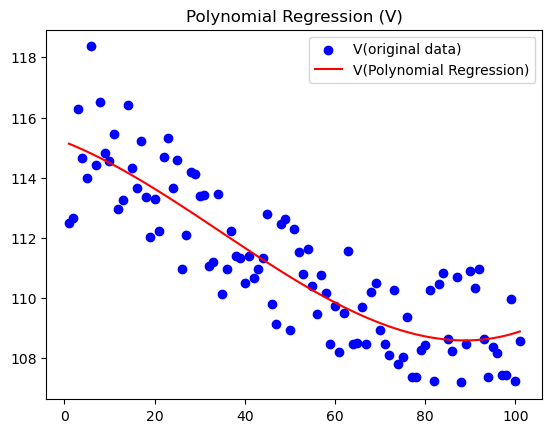

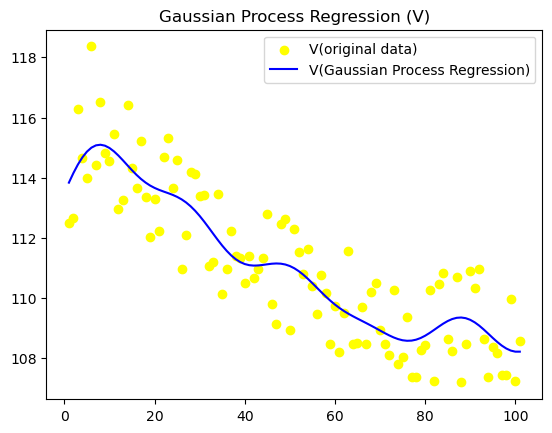

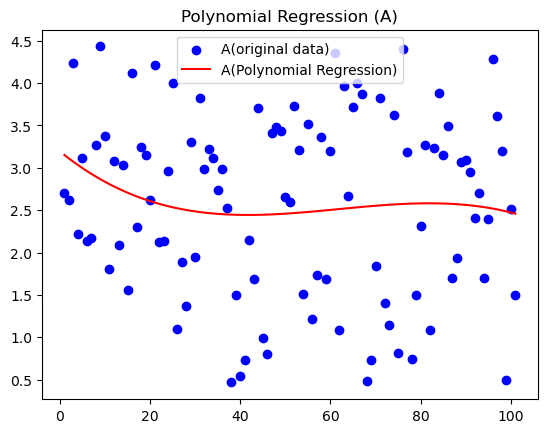

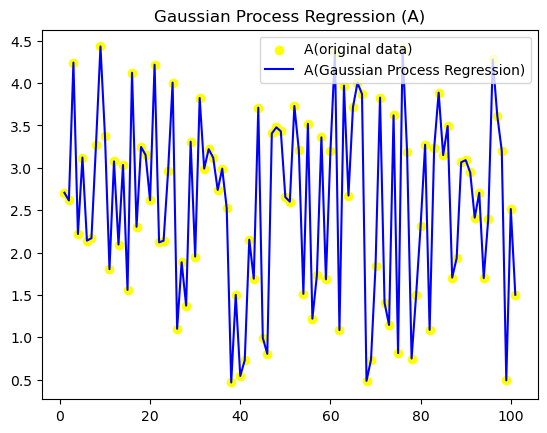

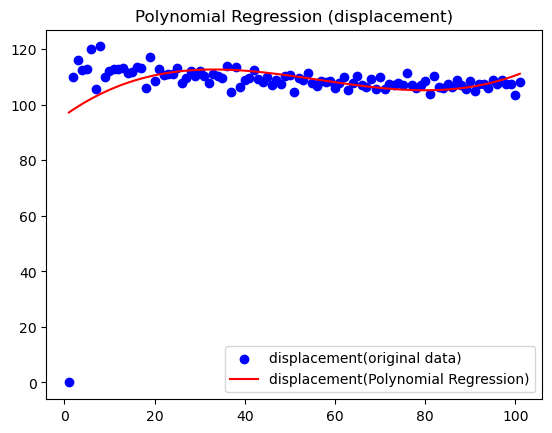

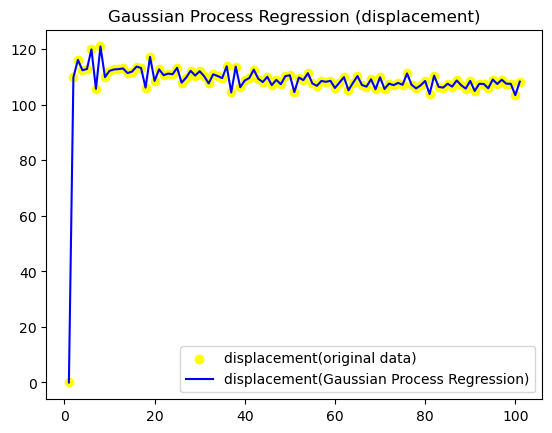

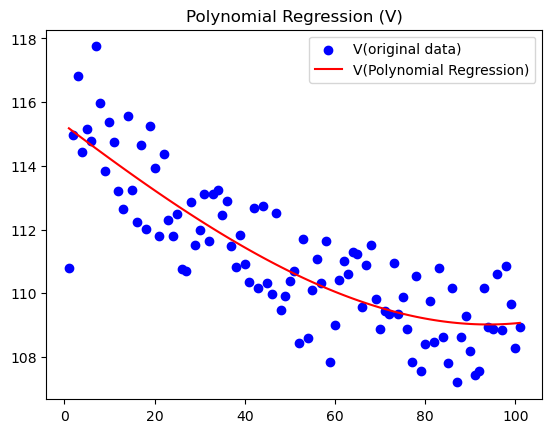

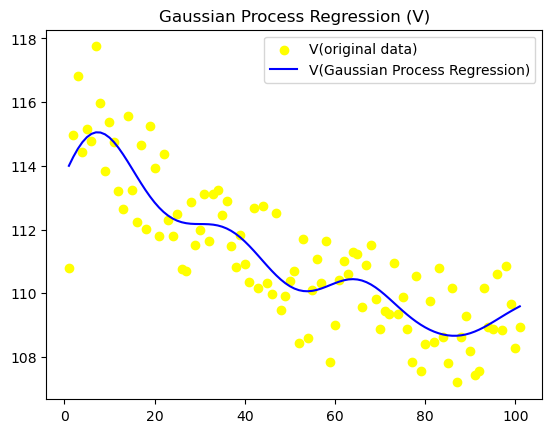

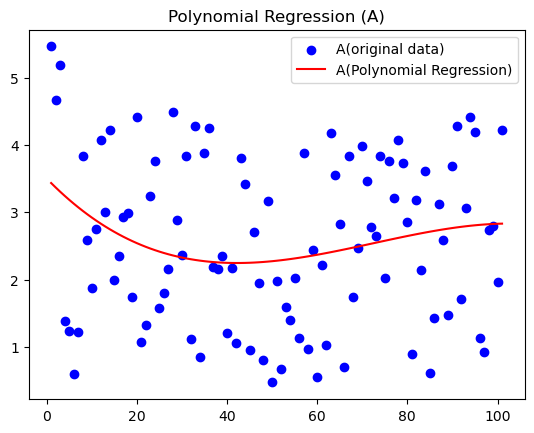

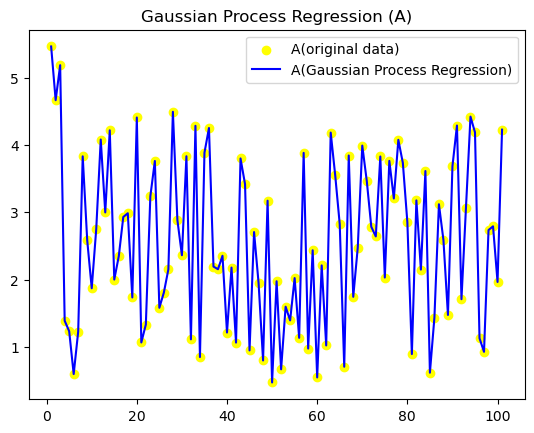

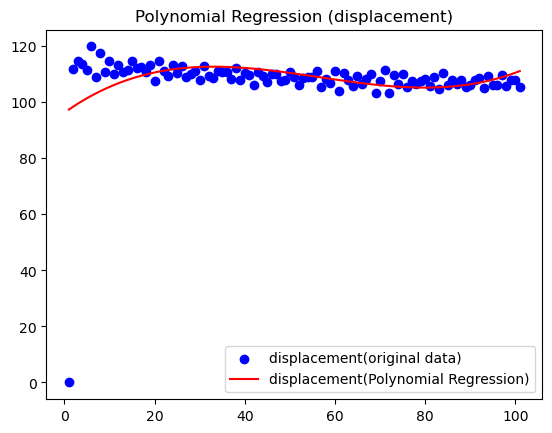

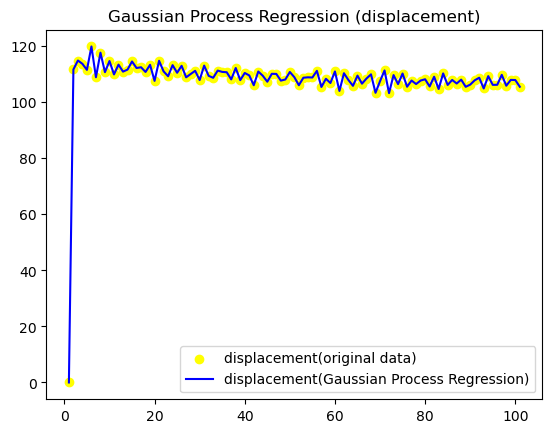

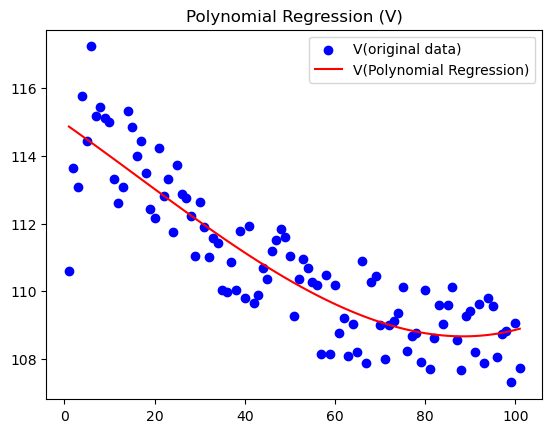

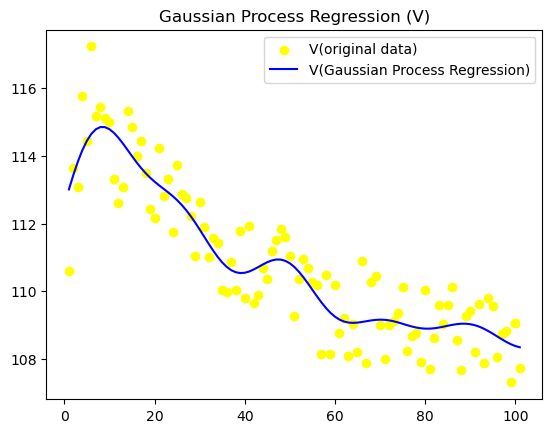

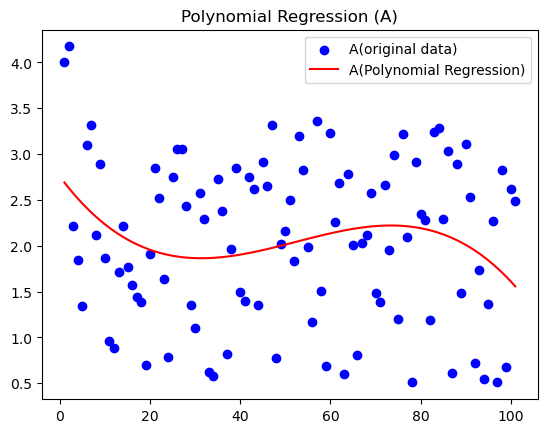

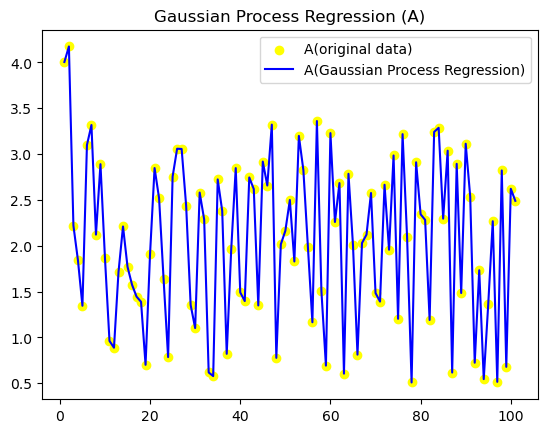

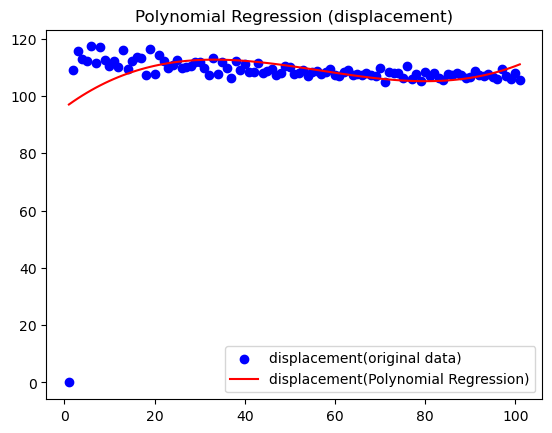

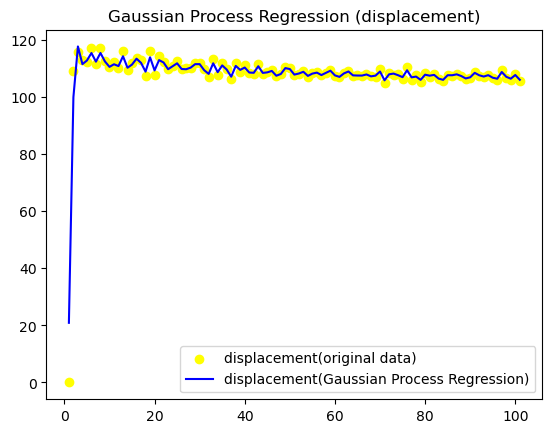

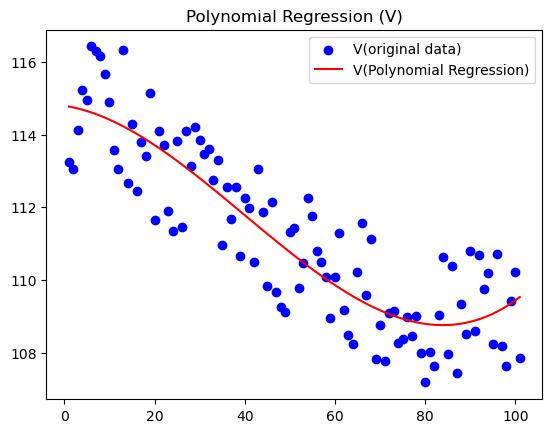

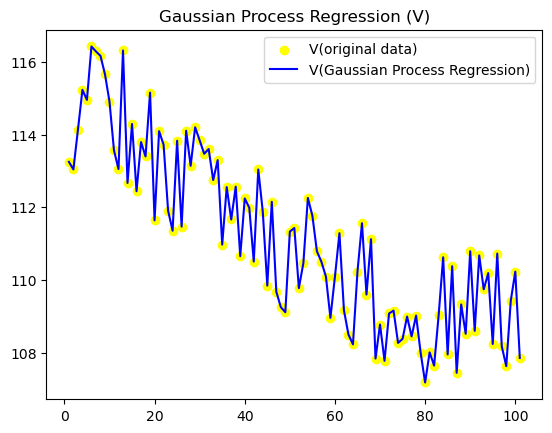

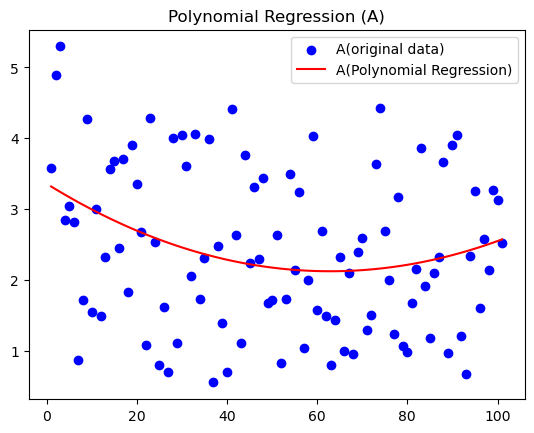

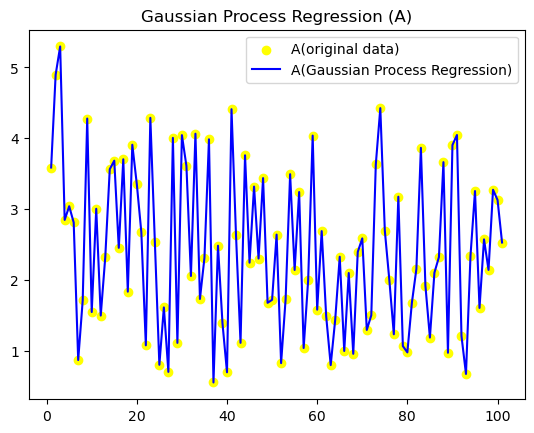

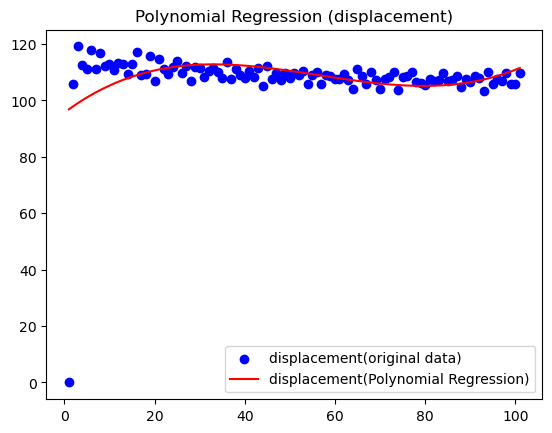

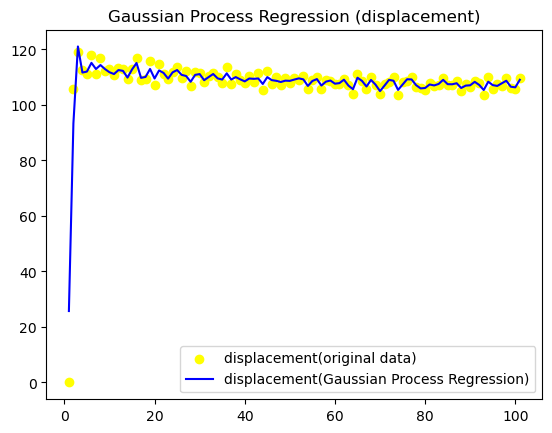

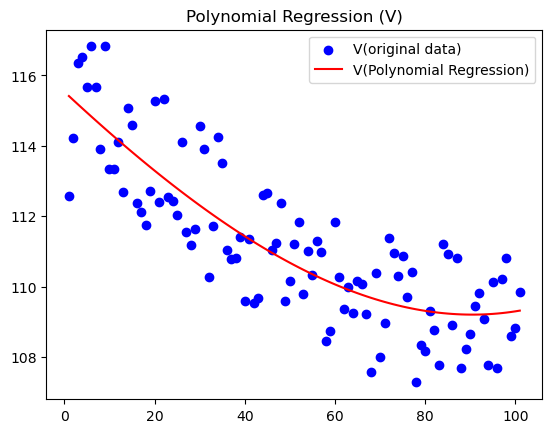

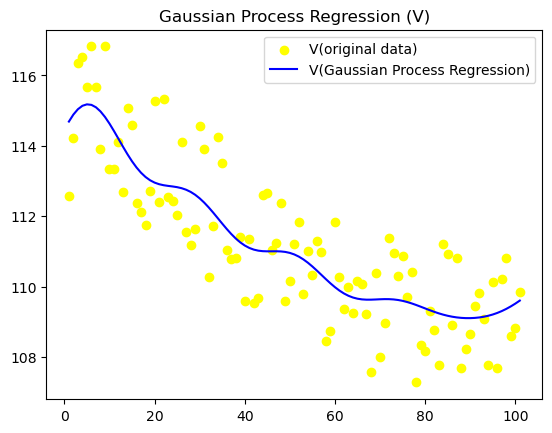

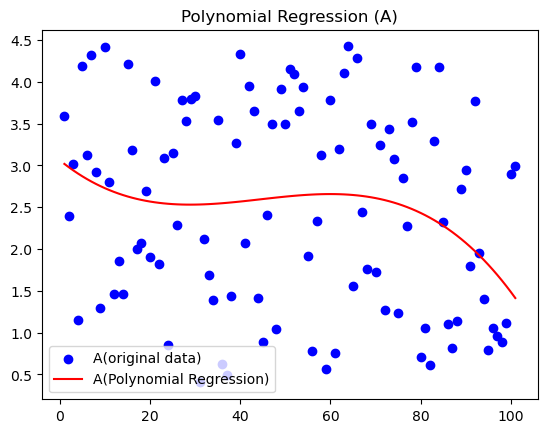

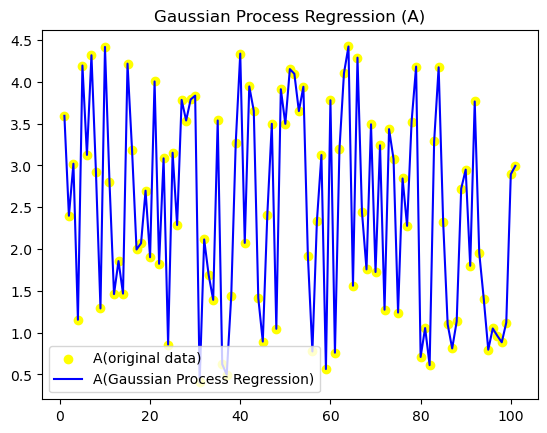

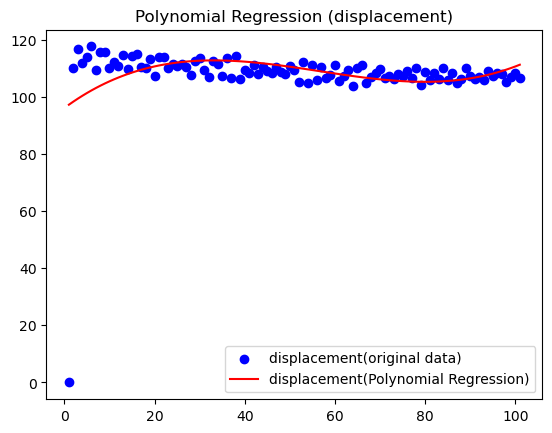

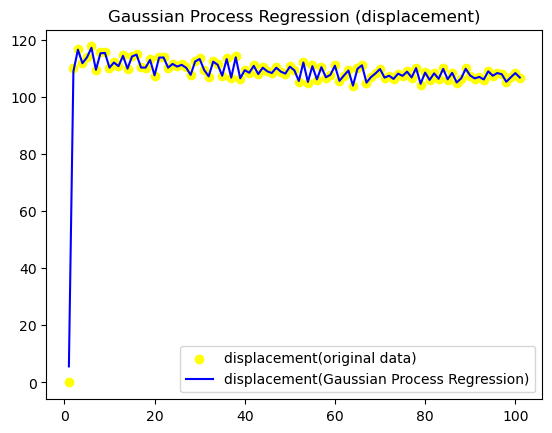

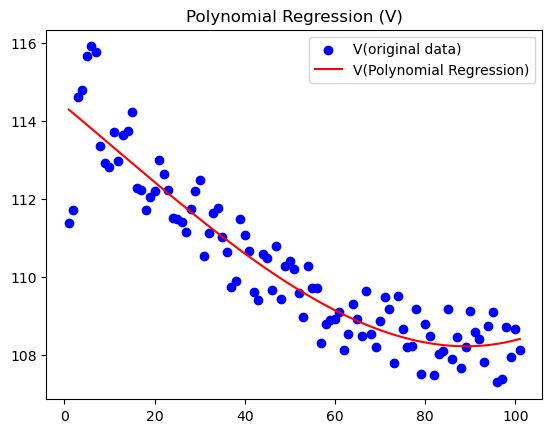

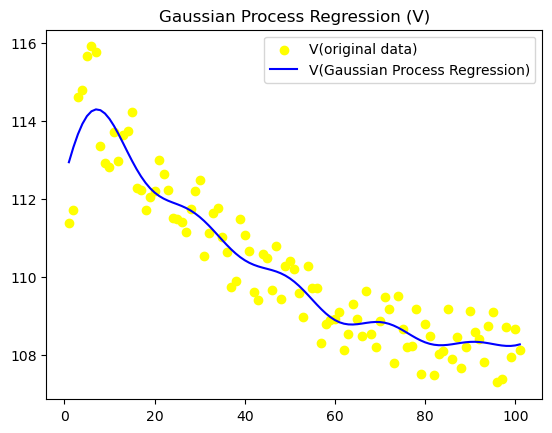

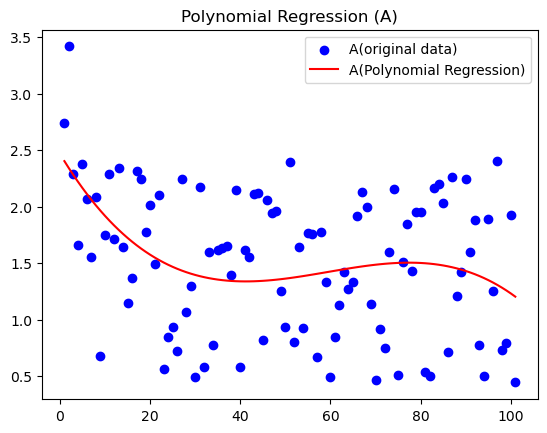

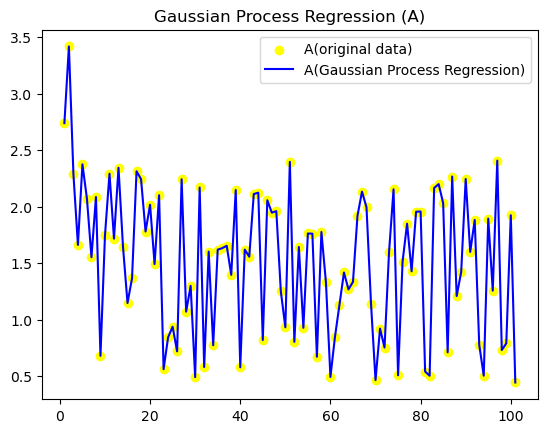

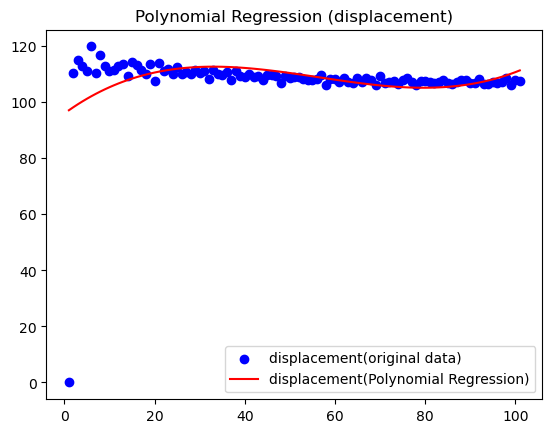

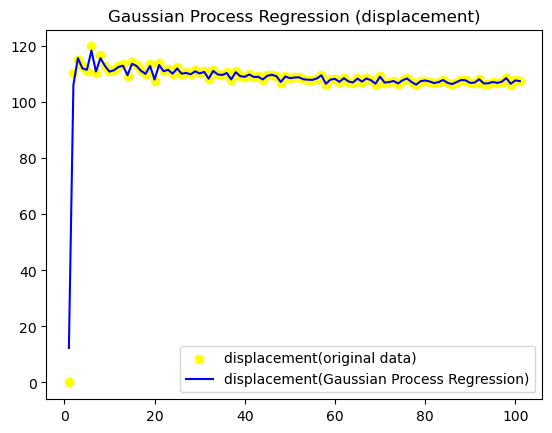

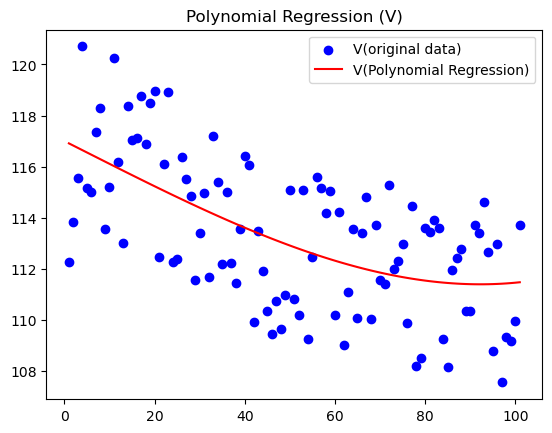

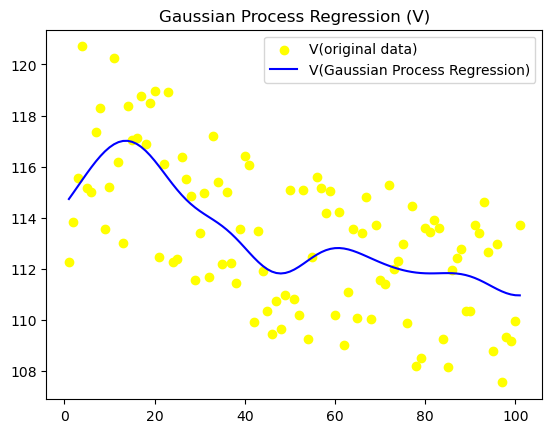

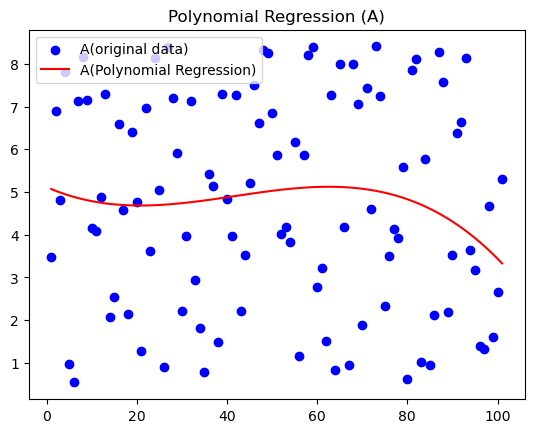

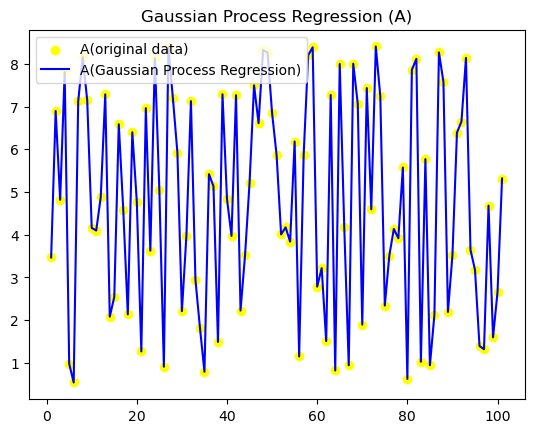

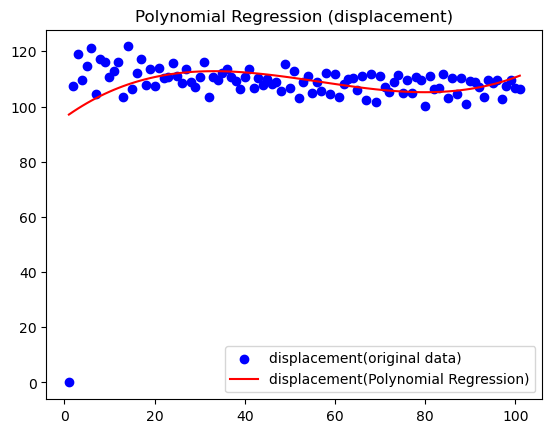

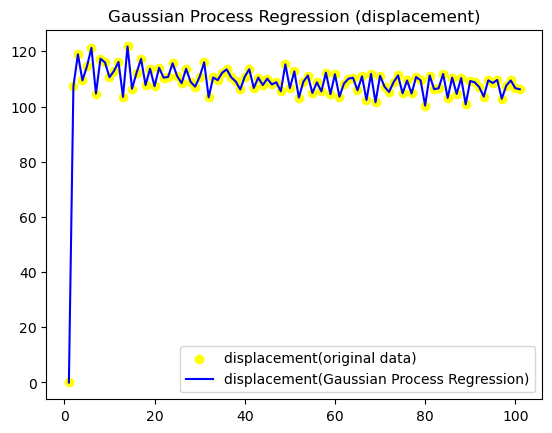

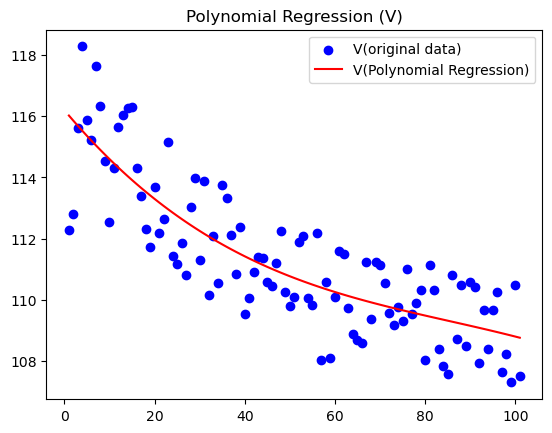

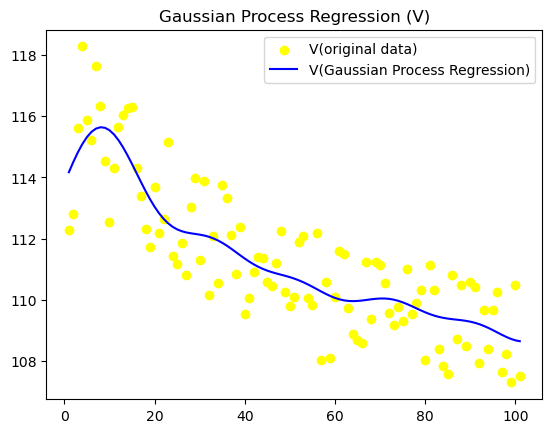

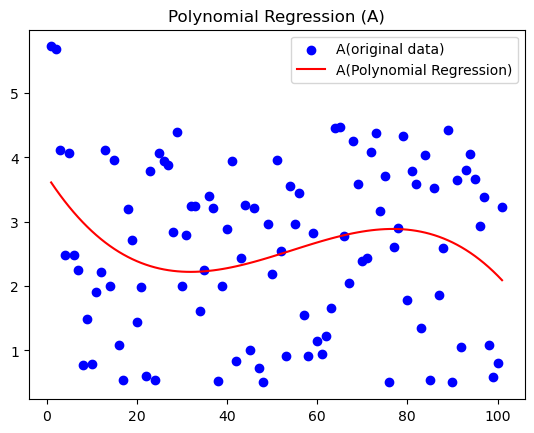

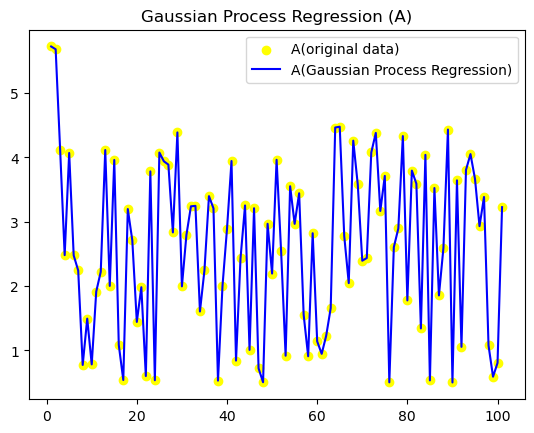

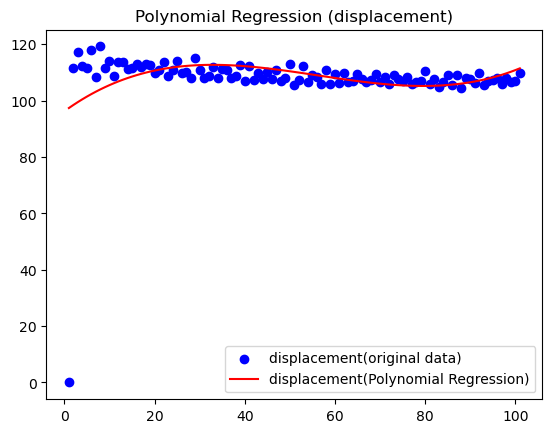

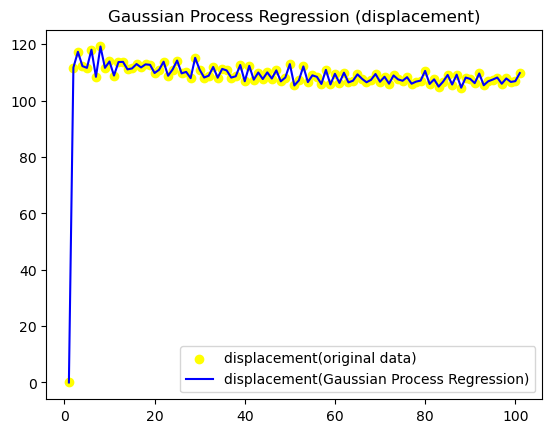

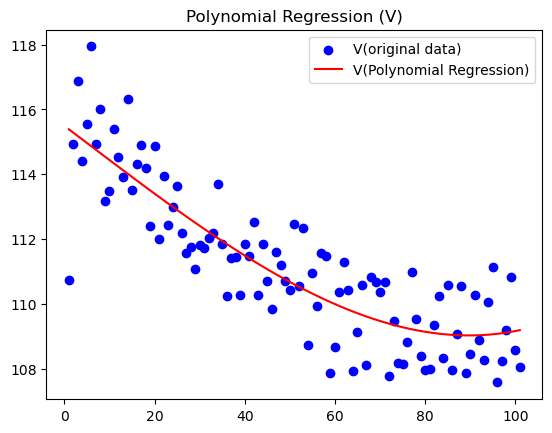

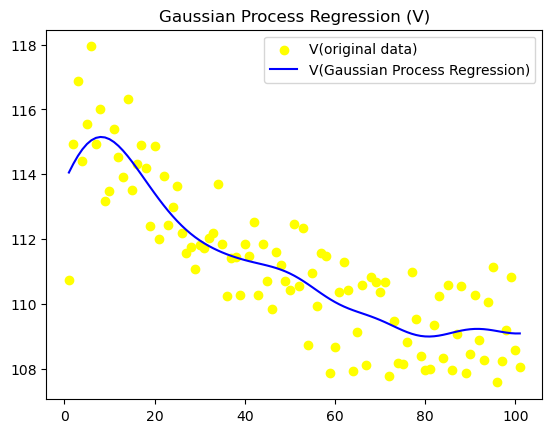

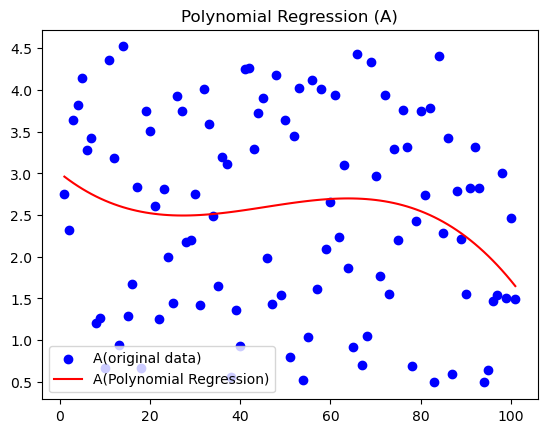

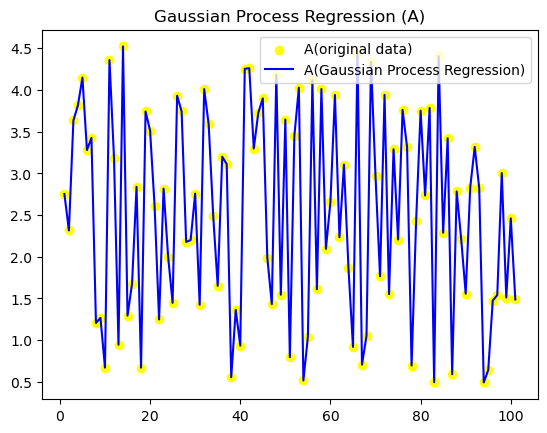

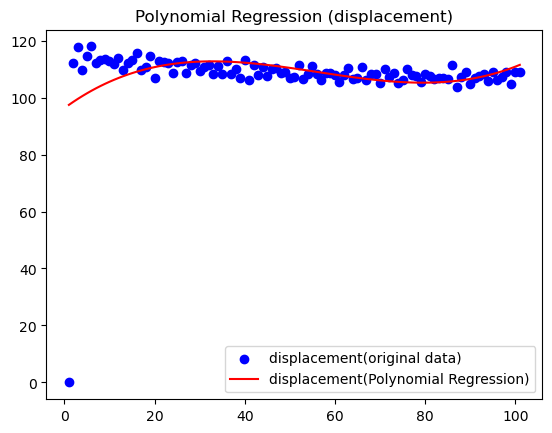

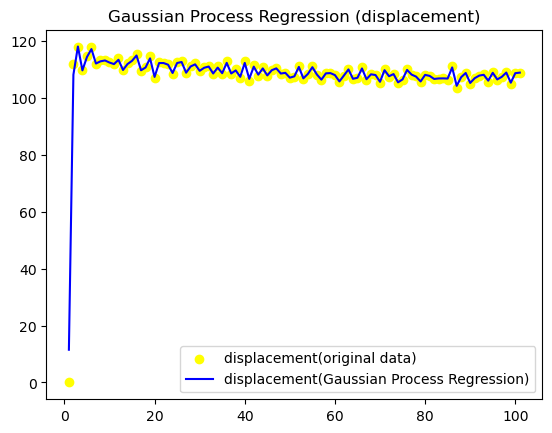

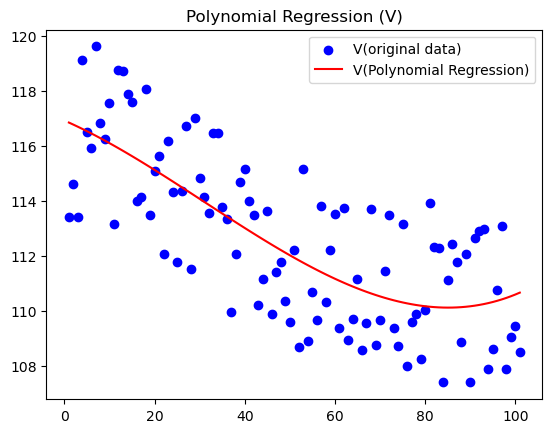

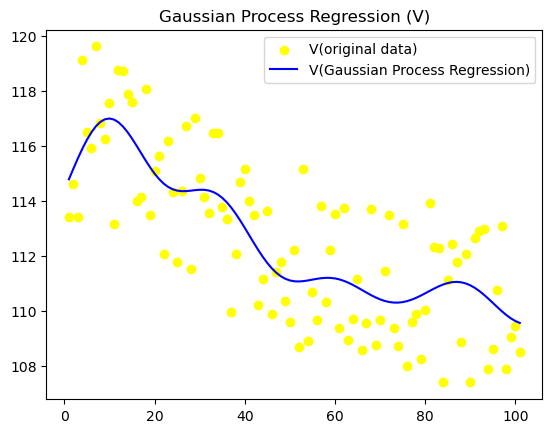

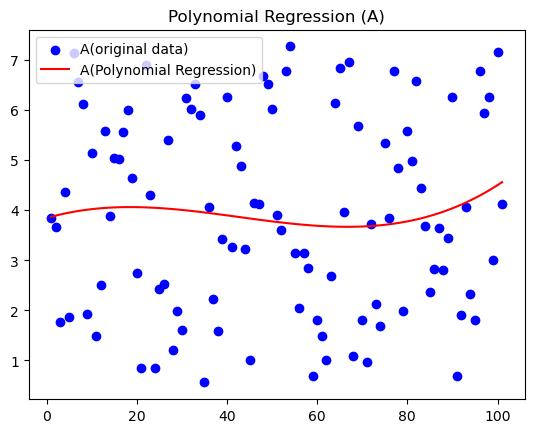

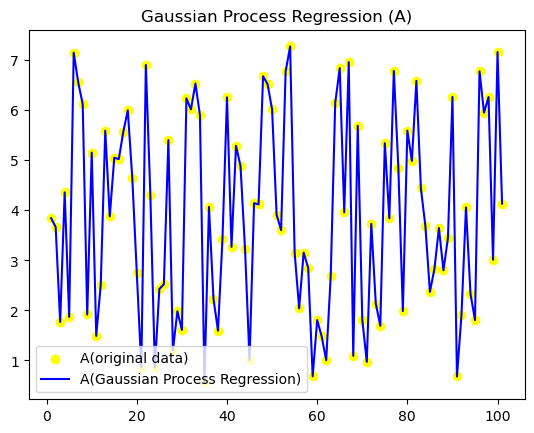

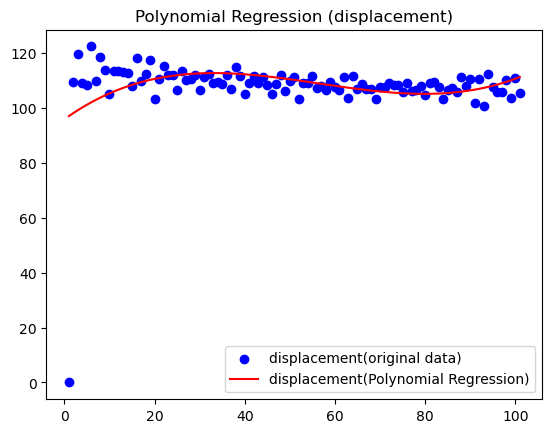

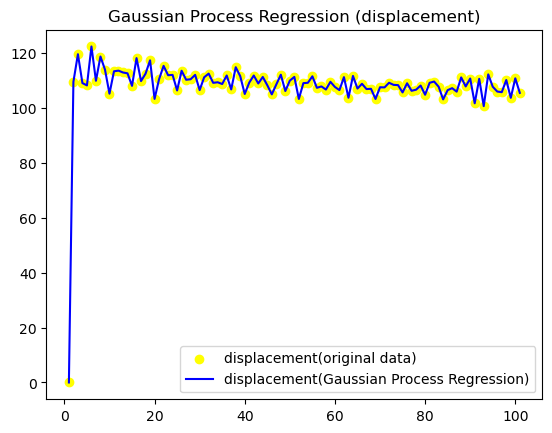

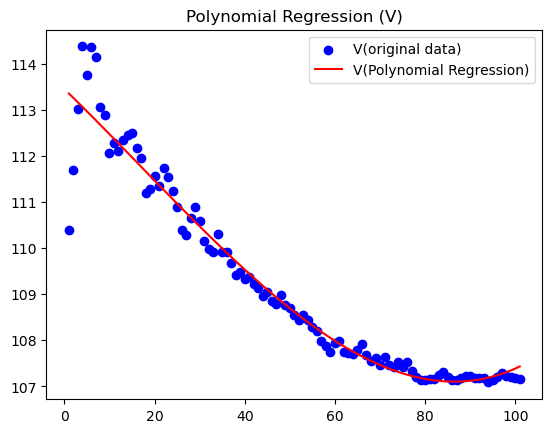

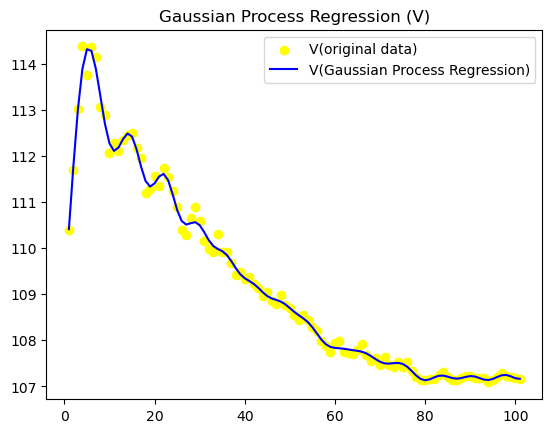

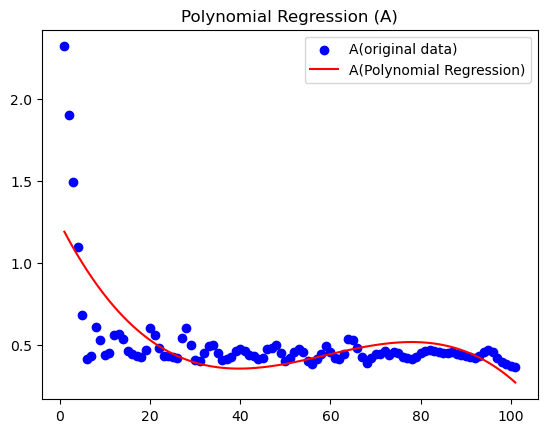

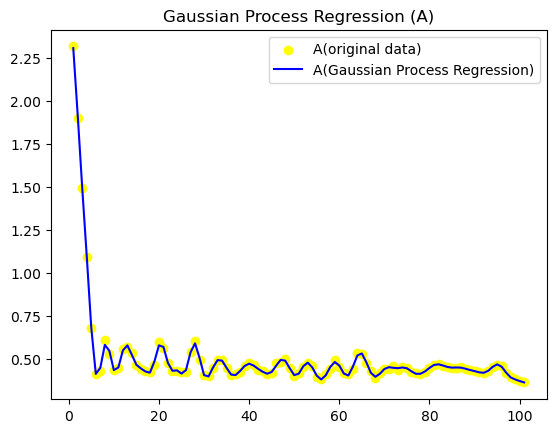

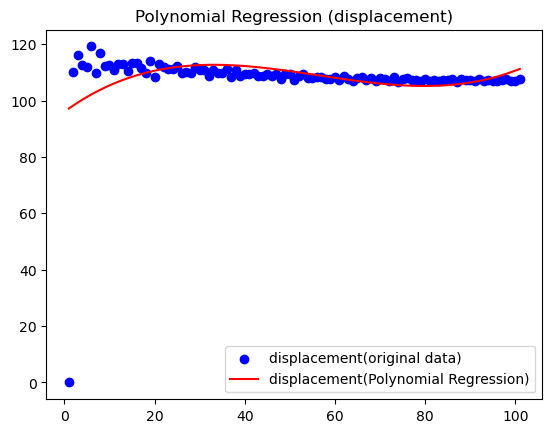

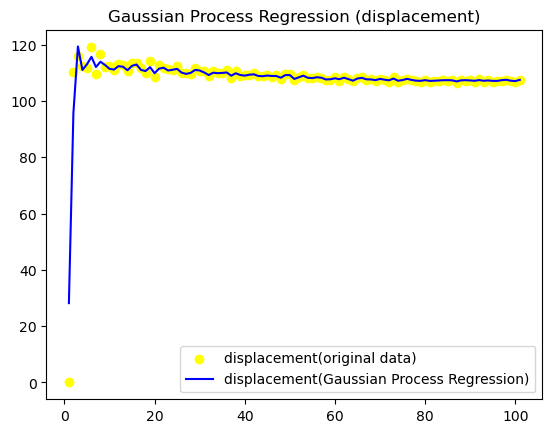

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
# from sklearn.ensemble import RandomForestRegressor
import glob
import zipfile
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# 读取Excel数据表并计算位移
def read_excel_and_calculate_displacement(file):
    file_extension = file.split('.')[-1]
    if file_extension == 'xlsx':
        engine = 'openpyxl'
    elif file_extension == 'xls':
        engine = 'xlrd'
    else:
        raise ValueError('Unsupported file extension.')
    try:
        table = pd.read_excel(file, engine=engine)
    except zipfile.BadZipFile:
        print(f"Error: BadZipFile for file {file}")
        return None
    table["dx"] = table["x"].diff().fillna(0)
    table["dy"] = table["y"].diff().fillna(0)
    table["dz"] = table["z"].diff().fillna(0)
    table["displacement"] = (table["dx"] ** 2 + table["dy"] ** 2 + table["dz"] ** 2) ** 0.5
    return table

# 多项式回归拟合
def polynomial_regression_fit(df, degree, target):
    x = df['T'].values.reshape(-1, 1)
    y = df[target].values

    poly = PolynomialFeatures(degree=degree)
    x_poly = poly.fit_transform(x)

    model = LinearRegression()
    model.fit(x_poly, y)
    y_pred = model.predict(x_poly)
    
    # 计算MSE和R-squared指标
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    print(f"Polynomial Regression ({target}): MSE = {mse:.4f}, R-squared = {r2:.4f}")
    
    # 可视化拟合曲线
    plt.figure()
    plt.scatter(x,y,color='blue',label=f"{target}(original data)")
    plt.plot(np.sort(x,axis=0),model.predict(poly.fit_transform(np.sort(x,axis=0))),color='red',label=f"{target}(Polynomial Regression)")
    plt.title(f"Polynomial Regression ({target})")
     # 添加图例、坐标轴标签等信息
    plt.legend(loc='best')
#     return model.predict(x_poly)
#     return y_pred, mse, r2
    return y_pred


# # Gaussian Process Regression
# def gaussian_process_regression_fit(df, target):
#     x = df['T'].values.reshape(-1, 1)
#     y = df[target].values

#     kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)) + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-10, 1e+1))
#     model = GaussianProcessRegressor(kernel=kernel, alpha=0.0, normalize_y=True, n_restarts_optimizer=10)
#     model.fit(x, y)
#     y_pred = model.predict(x)
    
#      # 计算MSE和R-squared指标
#     mse = mean_squared_error(y, y_pred)
#     r2 = r2_score(y, y_pred)
#     print(f"Gaussian Process Regression ({target}): MSE = {mse:.4f}, R-squared = {r2:.4f}")
    
#     # 可视化拟合曲线
#     plt.figure()
#     plt.scatter(x,y,color='blue',label=f"{target}(original data)")
#     plt.plot(x, y_pred, color='red', label=f"{target}(Gaussian Process Regression)")
#      # 添加图例、坐标轴标签等信息
#     plt.legend(loc='best')
# #     return y_pred, mse, r2
#     return y_pred


from sklearn.model_selection import GridSearchCV

def gaussian_process_regression_fit(df, target):
    """
    定义了参数空间param_grid，即要搜索的参数范围。然后我们定义了一个GridSearchCV对象，用于在参数空间内搜索最佳参数。
    最后我们对模型进行了训练和拟合，输出了最佳参数和评估指标，并绘制了预测结果和原始数据的散点图和拟合曲线。
    对径向基函数的长度尺度和白噪声的噪声级别进行优化。"""
    x = df['T'].values.reshape(-1, 1)
    y = df[target].values

    # 径向基函数 
    kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)) + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-10, 1e+1))

    # 定义参数空间
    param_grid = {'kernel__k1__length_scale': np.linspace(0.1, 10, 10),
                  'kernel__k2__noise_level': np.linspace(0.1, 10, 10)}

    # 定义GridSearchCV对象
    model = GaussianProcessRegressor(kernel=kernel, alpha=0.0, normalize_y=True, n_restarts_optimizer=10)
    grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, n_jobs=-1)

    # 对模型进行训练和拟合
    grid_search.fit(x, y)

    # 输出最佳参数和对应的得分
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best score: {grid_search.best_score_}")

    # 输出预测结果和评估指标
    y_pred = grid_search.predict(x)
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    print(f"Gaussian Process Regression ({target}): MSE = {mse:.4f}, R-squared = {r2:.4f}")

    # 绘制预测结果和原始数据的散点图和拟合曲线
    plt.figure()
    plt.scatter(x,y,color='blue',label=f"{target}(original data)")
    plt.plot(x, y_pred, color='yellow', label=f"{target}(Gaussian Process Regression)")
    plt.title(f"Gaussian Process Regression ({target})")
    plt.legend(loc='best')
    return y_pred



# 计算偏差
def calculate_deviation(df, y_pred, target):
    deviation = df[target] - y_pred
    return deviation

# 结果输出
def output_results(df, file_name):
    df.to_csv(file_name, index=False, encoding='utf-8')

# 处理数据表
def process_dataframe(df, degree=3):
    for target in ['V', 'A', 'displacement']:
#         y_pred = polynomial_regression_fit(df, degree, target)
#         deviation = calculate_deviation(df, y_pred, target)
#         df[f'{target}_pred'] = y_pred
#         df[f'{target}_deviation'] = deviation
        y_pred_poly = polynomial_regression_fit(df, degree, target)
        y_pred_gpr = gaussian_process_regression_fit(df, target)
        deviation_poly = calculate_deviation(df, y_pred_poly, target)
        deviation_gpr = calculate_deviation(df, y_pred_gpr, target)
        df[f'{target}_pred_poly'] = y_pred_poly
        df[f'{target}_pred_gpr'] = y_pred_gpr
        df[f'{target}_deviation_poly'] = deviation_poly
        df[f'{target}_deviation_gpr'] = deviation_gpr
        
         # 比较两种拟合效果，保存更好的结果
        mse_poly = mean_squared_error(df[target], y_pred_poly)
        mse_gpr = mean_squared_error(df[target], y_pred_gpr)
        if mse_gpr < mse_poly:
            df[f'{target}_pred'] = y_pred_gpr
            df[f'{target}_deviation'] = deviation_gpr
        else:
            df[f'{target}_pred'] = y_pred_poly
            df[f'{target}_deviation'] = deviation_poly
            
    output_file_name = f"{file.replace('.xlsx', '')}_processed.csv"
    print(f"Saving processed data to {output_file_name}")
    output_results(df, output_file_name)
    return df

# 主程序
data_files = glob.glob("./*.xlsx")
degree = 3

for file in data_files:
#   if file.startswith('instrument'):
    input_df = read_excel_and_calculate_displacement(file)
    if input_df is not None:
        output_df = process_dataframe(input_df, degree)
        print(f'{file} Done!')
        print("--------------------------------------------")
#             output_file = file.replace('.xlsx', '_output.csv')
#             output_results(output_df, output_file)
#             print(file)


| 字段 | 含义 |
| --- | --- |
| T | 时间 |
| x | 物体在x轴上的位置 |
| y | 物体在y轴上的位置 |
| z | 物体在z轴上的位置 |
| Vx | 物体在x轴上的速度 |
| Vy | 物体在y轴上的速度 |
| Vz | 物体在z轴上的速度 |
| V | 物体的速度 |
| Ax | 物体在x轴上的加速度 |
| Ay | 物体在y轴上的加速度 |
| Az | 物体在z轴上的加速度 |
| A | 物体的加速度 |
| dx | x轴上的位移变化 |
| dy | y轴上的位移变化 |
| dz | z轴上的位移变化 |
| displacement | 物体的位移 |
| V_pred_poly | 用多项式模型预测的物体速度 |
| V_pred_gpr | 用高斯过程回归模型预测的物体速度 |
| V_deviation_poly | 多项式模型对物体速度的预测偏差 |
| V_deviation_gpr | 高斯过程回归模型对物体速度的预测偏差 |
| V_pred | 综合多项式模型和高斯过程回归模型的预测物体速度 |
| V_deviation | 多项式模型和高斯过程回归模型对物体速度的综合预测偏差 |
| A_pred_poly | 用多项式模型预测的物体加速度 |
| A_pred_gpr | 用高斯过程回归模型预测的物体加速度 |
| A_deviation_poly | 多项式模型对物体加速度的预测偏差 |
| A_deviation_gpr | 高斯过程回归模型对物体加速度的预测偏差 |
| A_pred | 综合多项式模型和高斯过程回归模型的预测物体加速度 |
| A_deviation | 多项式模型和高斯过程回归模型对物体加速度的综合预测偏差 |
| displacement_pred_poly | 用多项式模型预测的物体位移 |
| displacement_pred_gpr | 用高斯过程回归模型预测的物体位移 |
| displacement_deviation_poly | 多项式模型对物体位移的预测偏差 |
| displacement_deviation_gpr | 高斯过程回归模型对物体位移的预测偏差 |
| displacement_pred | 综合多项式模型和高斯过程回归模型的预测物体位移 |
| displacement_deviation | 多项式模型和高斯过程回归模型对物体位移的综合预测偏差 |

https://zhangzhenhu.github.io/blog/glm/source/%E9%AB%98%E6%96%AF%E6%A8%A1%E5%9E%8B/content.html
https://help.aliyun.com/document_detail/325449.html

调整kernel参数：
length_scale: 径向基函数rbf的长度尺度，影响模型的平滑程度和拟合效果，

调整kernel参数：
length_scale：径向基函数(RBF)的长度尺度，影响模型的平滑程度和拟合效果，可通过调整length_scale_bounds来限制长度尺度的范围。
noise_level：噪声方差，影响模型的泛化能力和拟合效果，可通过调整noise_level_bounds来限制噪声方差的范围。
可以尝试不同的参数组合，观察模型在训练集上的性能，选择最优的参数组合。

调整model参数：
alpha：正则化参数，用于控制模型的复杂度和泛化能力，过高的alpha会导致欠拟合，过低的alpha会导致过拟合。
normalize_y：是否对目标变量进行标准化处理，可以帮助提高模型的稳定性和泛化能力。
n_restarts_optimizer：优化器的重启次数，可以帮助找到全局最优解。
可以通过交叉验证等方法，对不同的参数组合进行评估和选择。同时，还可以考虑对数据进行预处理和特征选择等操作，以提高模型的拟合效果和泛化能力。

### 参数优化 
对于GaussianProcessRegressor模型中的参数，通常推荐的取值范围如下：

length_scale：一般取值范围为[0.1, 10.0]，具体取值需要根据数据集的特点来定。  
length_scale_bounds：一般取值范围为(1e-3, 1e3)。  
noise_level：一般取值范围为[1e-10, 1e+1]，具体取值需要根据数据集的噪声程度来定。  
noise_level_bounds：一般取值范围为(1e-10, 1e+1)。  
alpha：一般取值范围为[1e-10, 1e+1]，具体取值需要根据数据集的复杂度和泛化能力来定。  
n_restarts_optimizer：一般取值范围为[1, 10]，具体取值需要根据数据集的规模和复杂度来定。  

这些取值范围仅供参考，具体的取值需要根据数据集的特点和模型的表现来定。在调参过程中，应该结合模型的性能和效果，进行适当的调整和优化。同时，可以尝试使用网格搜索、贝叶斯优化等方法，帮助自动化地搜索最优的参数组合。


有多种方法可以自动化搜索最优参数组合，下面介绍两种常用的方法：网格搜索和贝叶斯优化。

1. 网格搜索(Grid Search)
网格搜索是一种常见的参数调优方法，它通过穷举不同参数组合来搜索最优的参数。具体步骤如下：

定义要调优的参数范围和步长。
使用GridSearchCV函数构建模型，并设置参数范围。
调用fit函数进行训练，同时计算不同参数组合下的模型性能。
选择性能最好的参数组合，并用最优参数训练模型。


GridSearchCV是一种通过网格搜索的方式来寻找最优模型超参数的方法。具体的处理逻辑如下：

1.定义超参数范围：首先需要定义需要优化的模型超参数范围，例如在SVM模型中，超参数C的范围可以是[0.1, 1, 10]，gamma的范围可以是[0.001, 0.01, 0.1]等。


2.生成参数组合：GridSearchCV会根据定义的超参数范围生成一系列的参数组合，例如在SVM模型中，可能会生成以下参数组合：C=0.1, gamma=0.001；C=0.1, gamma=0.01；C=0.1, gamma=0.1；C=1, gamma=0.001；C=1, gamma=0.01；C=1, gamma=0.1；C=10, gamma=0.001；C=10, gamma=0.01；C=10, gamma=0.1。

3.交叉验证评估模型：对于每一组参数组合，GridSearchCV会对模型进行交叉验证，通过交叉验证来评估该组参数的表现。例如，可以将训练集划分为k个子集，每次取其中k-1个子集作为训练集，另一个子集作为验证集，计算该组参数在验证集上的性能表现，这个过程会重复k次。将每次验证结果的平均值作为该组参数的表现结果。

4.选择最优参数：在完成所有的参数组合的交叉验证后，GridSearchCV会根据所有参数组合的性能表现结果，选出表现最好的一组参数组合。这个过程可以通过GridSearchCV的best_params_属性来获得最优参数组合，通过best_score_属性来获得最优参数组合的平均得分。

总之，GridSearchCV通过对超参数范围进行遍历来寻找最优的模型超参数，其中采用了交叉验证来评估每个参数组合的性能，最终输出最优的参数组合及其性能表现。

下面是一个简单的网格搜索示例：


In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# 构建模型
kernel = RBF() + WhiteKernel()
model = GaussianProcessRegressor(kernel=kernel, alpha=0.0, normalize_y=True)

# 定义要调优的参数范围和步长
param_grid = {
    'kernel__length_scale': np.logspace(-1, 2, 10),
    'kernel__length_scale_bounds': [(1e-3, 1e3)],
    'kernel__noise_level': np.logspace(-10, 1, 10),
    'kernel__noise_level_bounds': [(1e-10, 1e1)],
    'alpha': np.logspace(-10, 1, 10),
    'n_restarts_optimizer': [2, 5, 10]
}

# 使用GridSearchCV函数构建模型，并设置参数范围
grid = GridSearchCV(model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# 训练模型
grid.fit(x_train, y_train)

# 输出最优参数和最优性能
print('Best parameters:', grid.best_params_)
print('Best negative mean squared error:', grid.best_score_)


2. 贝叶斯优化(Bayesian Optimization)
贝叶斯优化是一种基于概率模型的优化方法，它通过反复使用先验知识来更新后验分布，从而寻找最优解。具体步骤如下：

定义要调优的参数范围和优化目标函数。
使用贝叶斯优化库(如BayesianOptimization)来构建优化模型，并设置参数范围。
调用optimize函数进行优化，计算每个参数组合下的目标函数值。
选择目标函数值最小的参数组合，并用最优参数训练模型。